## Mikroserwis

W eksperymencie A/B mikroserwis losowo wybiera wariant modelu:

- **A (baseline)** – model bazowy
- **B (target)** – model docelowy

Zdarzenia są zapisywane w logu (JSONL):
- `predict`: `request_id`, `variant`, `prob`
- `feedback`: `request_id`, `true`

Notatnik:
1) wczytuje log i łączy `predict` z `feedback` po `request_id`,
2) definiuje miarę jakości na poziomie pojedynczego zapytania,
3) stawia hipotezy i weryfikuje je testem t-Studenta (jednostronnym),
4) podaje decyzję „czy B jest istotnie lepsze od A”.


#### Przykładowe wywołanie mikroserwisu

Poniżej przykład requestu. W praktyce wypełnij `features` cechami zgodnymi ze schematem wejścia mikroserwisu.


In [1]:
import requests

URL = "http://127.0.0.1:8000/predict"

payload = {
    "features": {
        # uzupełnij realnymi cechami:
        # "room_type": "Entire home/apt",
        # "accommodates": 2,
        # "amen_wifi": 1,
        # ...
    }
}

# response = requests.post(URL, json=payload, timeout=10)
# print(response.status_code, response.json())


### Oznaczenia

W analizie porównujemy średnią wartość miary jakości w dwóch wariantach. Ponieważ problem jest klasyfikacją binarną z prawdopodobieństwem `prob = P(y=1)`,
stosujemy miarę zdefiniowaną **dla pojedynczego zapytania** (pojedynczej próbki).

Użyta miara (per-request):
- **logloss**:  \(\ell = -[y\log(p) + (1-y)\log(1-p)]\)  (mniej = lepiej)

W dalszej części:
- \(q_A\) – średni logloss wariantu A
- \(q_B\) – średni logloss wariantu B
- \(\Delta = q_A - q_B\) – obserwowana poprawa (jeśli dodatnia, B ma mniejszy logloss)


### Hipotezy

Chcemy sprawdzić, czy wariant **B** jest lepszy (ma mniejszy logloss) od wariantu **A**.

- Hipoteza zerowa \(H_0\): \(q_B \ge q_A\)  (B nie jest lepsze od A)
- Hipoteza alternatywna \(H_1\): \(q_B < q_A\) (B jest lepsze od A)

Równoważnie dla poprawy \(\Delta = q_A - q_B\):
- \(H_0\): \(\Delta \le 0\)
- \(H_1\): \(\Delta > 0\)


### Przyjęte parametry

Ustalamy:
- poziom istotności \(\alpha\),
- moc testu \(1-\beta\),
- **MDE** (minimal detectable effect) – minimalna poprawa, która ma sens praktyczny.

Ponieważ miarą jest logloss, MDE interpretujemy jako minimalny spadek średniego logloss.
W notatniku MDE ustawiamy jako ułamek średniego logloss wariantu A (np. 2%).


In [2]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import norm, ttest_ind

LOG_PATH = Path("../logs/ab_log.jsonl")
try:
    from src.utils.constants import AB_LOG_PATH as LOG_PATH  # type: ignore
except Exception:
    pass

assert LOG_PATH.exists(), f"Missing log file: {LOG_PATH.resolve()}"
print("Using log:", LOG_PATH.resolve())

def load_jsonl(path: Path) -> pd.DataFrame:
    rows = []
    for i, line in enumerate(path.read_text(encoding="utf-8").splitlines(), start=1):
        line = line.strip()
        if not line:
            continue
        try:
            rows.append(json.loads(line))
        except json.JSONDecodeError:
            print(f"[warn] invalid JSON on line {i}, skipping")
    return pd.DataFrame(rows)

df = load_jsonl(LOG_PATH)

pred = df.loc[df["event"] == "predict"].copy()
fb = df.loc[df["event"] == "feedback"].copy()

pred_keep = ["request_id", "variant", "prob"]
for c in ["ts", "model", "pred", "user_id", "listing_id"]:
    if c in pred.columns:
        pred_keep.append(c)
pred = pred[pred_keep].copy()

fb = fb[["request_id", "true"]].copy()

need_pred = {"request_id", "variant", "prob"}
need_fb = {"request_id", "true"}
assert need_pred.issubset(pred.columns), f"predict missing: {sorted(need_pred - set(pred.columns))}"
assert need_fb.issubset(fb.columns), f"feedback missing: {sorted(need_fb - set(fb.columns))}"

m = pred.merge(fb, on="request_id", how="inner", validate="1:1")

m = m.rename(columns={"true": "y_true", "prob": "p"})
m["y_true"] = m["y_true"].astype(int)
m["p"] = m["p"].astype(float)



Using log: /home/kamil/ium/logs/ab_log.jsonl


### Obliczenie miary jakości (logloss) dla pojedynczej próbki

W logu mamy prawdopodobieństwo `p` oraz etykietę `y_true`.
Wyliczamy `loss` dla każdej próbki i tworzymy dwie grupy: A oraz B.


In [3]:
EPS = 1e-15
p = np.clip(m["p"].to_numpy(), EPS, 1 - EPS)
y = m["y_true"].to_numpy()

m["loss"] = -(y * np.log(p) + (1 - y) * np.log(1 - p))

group_A = m.loc[m["variant"] == "A", "loss"].to_numpy()
group_B = m.loc[m["variant"] == "B", "loss"].to_numpy()

print(f"Number of samples: A: {len(group_A)}, B: {len(group_B)}, Total: {len(group_A) + len(group_B)}")
print(f"Mean logloss:      A: {np.mean(group_A):.6f}, B: {np.mean(group_B):.6f}")
print(f"Std dev logloss:   A: {np.std(group_A, ddof=1):.6f}, B: {np.std(group_B, ddof=1):.6f}")


Number of samples: A: 49967, B: 50033, Total: 100000
Mean logloss:      A: 0.459848, B: 0.214183
Std dev logloss:   A: 0.588351, B: 0.454773


### Dobór MDE na podstawie danych pilotowych

MDE ustawiamy jako względny spadek średniego logloss wariantu A.
Przykład: `mde_rel = 0.02` oznacza, że minimalnie interesuje nas poprawa o 2% średniego logloss wariantu A.


In [4]:
alpha = 0.05
power = 0.80

mde_rel = 0.02  # <- możesz zmienić, np. 0.01 (1%) lub 0.03 (3%)

mean_A = float(np.mean(group_A))
std_A = float(np.std(group_A, ddof=1))
std_B = float(np.std(group_B, ddof=1))

mde = mde_rel * mean_A  # minimalny spadek logloss (A - B)
print(f"alpha={alpha}, power={power}")
print(f"pilot mean logloss A={mean_A:.6f}")
print(f"MDE (abs) = {mde:.6f}  (={mde_rel:.1%} of mean_A)")


alpha=0.05, power=0.8
pilot mean logloss A=0.459848
MDE (abs) = 0.009197  (=2.0% of mean_A)


### Wyznaczanie liczby potrzebnych próbek

Do oszacowania liczby próbek stosujemy test t dwóch niezależnych prób (warianty A i B).
Wykorzystujemy oszacowane odchylenie standardowe i przyjęte MDE.

Wynik `n_required` oznacza liczbę obserwacji **na wariant** (A oraz B), przy założeniu równych rozmiarów grup.


In [5]:
# pooled std (jak w typowych wyliczeniach mocy)
std_pooled = float(np.sqrt((std_A**2 + std_B**2) / 2.0))
effect_size = mde / std_pooled if std_pooled > 0 else np.nan

n_required = None

try:
    from statsmodels.stats.power import TTestIndPower  # type: ignore

    analysis = TTestIndPower()
    n_required = float(
        analysis.solve_power(
            effect_size=effect_size, alpha=alpha, power=power, ratio=1.0, alternative="larger"
        )
    )
    method = "statsmodels (TTestIndPower)"
except Exception:
    # przybliżenie normalne (duże n): n ≈ 2 * ((z_{1-α} + z_{1-β}) * σ / MDE)^2
    z_alpha = float(norm.ppf(1 - alpha))
    z_beta = float(norm.ppf(power))
    n_required = float(2.0 * (((z_alpha + z_beta) * std_pooled) / max(mde, 1e-12)) ** 2)
    method = "normal approximation"

print("Method:", method)
print(f"pooled std={std_pooled:.6f}, effect_size={effect_size:.6f}")
print(f"Estimated n per variant needed: {n_required:.1f}")
print(f"Total sample size: {2*n_required:.1f}")


Method: statsmodels (TTestIndPower)
pooled std=0.525821, effect_size=0.017491
Estimated n per variant needed: 40419.7
Total sample size: 80839.3


### Wyznaczanie wartości krytycznej dla poprawy Δ

Definiujemy poprawę:
\[
\Delta = q_A - q_B
\]
gdzie \(q_A\) i \(q_B\) to średni logloss.

Wartość krytyczna (przybliżenie normalne):
\[
\Delta_{crit} = z_{1-\alpha}\cdot SE
\]
gdzie
\[
SE = \sqrt{\frac{\sigma_A^2}{n} + \frac{\sigma_B^2}{n}}
\]
a \(n\) to liczba obserwacji na wariant.


In [6]:
n = n_required

se = float(np.sqrt((std_A**2 / n) + (std_B**2 / n)))
z_crit = float(norm.ppf(1 - alpha))
delta_crit = float(z_crit * se)

print(f"Standard error (SE): {se:.6f}")
print(f"Critical z (1-alpha): {z_crit:.6f}")
print(f"Critical value (Delta_crit): {delta_crit:.6f} logloss")


Standard error (SE): 0.003699
Critical z (1-alpha): 1.644854
Critical value (Delta_crit): 0.006084 logloss


### Metodyka testu

Każde wywołanie mikroserwisu realizuje predykcję i zapisuje:
- wariant modelu A/B,
- prawdopodobieństwo `prob`.

Etykieta `true` jest dopisywana w osobnym zdarzeniu `feedback` (np. po poznaniu rzeczywistego wyniku).
Ewaluacja łączy te dwa zdarzenia po `request_id`.


### Wynik testu statystycznego

Warunki weryfikacji hipotezy:
1) dane są wystarczające: liczba oznaczonych obserwacji w A i B osiąga `n_required`,
2) obserwowana poprawa \(\Delta\) jest co najmniej na poziomie MDE,
3) test t-Studenta (Welch) daje `p_value < alpha` dla hipotezy jednostronnej \(\Delta > 0\).


In [7]:
data_sufficient = (len(group_A) >= n_required) and (len(group_B) >= n_required)

if data_sufficient:
    observed_delta = float(np.mean(group_A) - np.mean(group_B))  # A - B, dodatnia = B lepsze
    se_obs = float(np.sqrt((np.var(group_A, ddof=1) / len(group_A)) + (np.var(group_B, ddof=1) / len(group_B))))
    delta_crit_obs = float(norm.ppf(1 - alpha) * se_obs)

    # scipy>=1.9: ttest_ind supports alternative
    try:
        t_stat, p_value = ttest_ind(group_A, group_B, equal_var=False, alternative="greater")
        p_one = float(p_value)
    except TypeError:
        # fallback: compute two-sided then convert
        t_stat, p_two = ttest_ind(group_A, group_B, equal_var=False)
        p_one = float(p_two / 2) if t_stat > 0 else float(1 - p_two / 2)

    stat_significant = p_one < alpha
    practical_significant = observed_delta >= mde

    print("--- Data reliability ---")
    print(f"Sample size reached: A={len(group_A)} B={len(group_B)} (Required per variant: {int(np.ceil(n_required))})")
    print(f"Observed improvement Δ = mean(A)-mean(B): {observed_delta:.6f} logloss")
    print(f"MDE: {mde:.6f} logloss")
    print(f"Critical value Δ_crit (based on observed SE): {delta_crit_obs:.6f} logloss")
    print("")
    print("--- Welch t-test (one-sided: mean(A) > mean(B)) ---")
    print(f"t_stat: {float(t_stat):.6f}")
    print(f"p_value (one-sided): {p_one:.6g}")
    print("")
    print("--- Decision ---")
    if stat_significant and practical_significant:
        print(f"Reject H0. Accept H1: B improves logloss (Δ={observed_delta:.6f}, p={p_one:.6g}).")
    elif not stat_significant:
        print(f"Do not reject H0: no statistical evidence that B is better (p={p_one:.6g}).")
    else:
        print(f"Do not reject H0: improvement < MDE (Δ={observed_delta:.6f} < {mde:.6f}).")
else:
    print(
        f"NOT sufficient data. Collected A={len(group_A)}/{int(np.ceil(n_required))}, "
        f"B={len(group_B)}/{int(np.ceil(n_required))} labeled samples."
    )


--- Data reliability ---
Sample size reached: A=49967 B=50033 (Required per variant: 40420)
Observed improvement Δ = mean(A)-mean(B): 0.245665 logloss
MDE: 0.009197 logloss
Critical value Δ_crit (based on observed SE): 0.005471 logloss

--- Welch t-test (one-sided: mean(A) > mean(B)) ---
t_stat: 73.865107
p_value (one-sided): 0

--- Decision ---
Reject H0. Accept H1: B improves logloss (Δ=0.245665, p=0).


#### Dodatkowa wizualizacja

Porównanie rozkładów logloss w wariantach A i B.


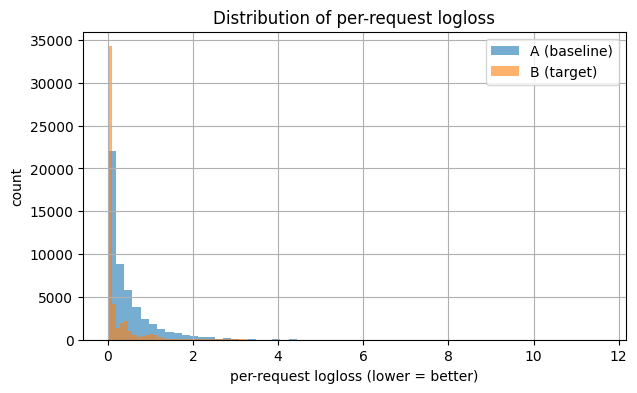

In [8]:
plt.figure(figsize=(7, 4))
plt.hist(group_A, bins=60, alpha=0.6, label="A (baseline)")
plt.hist(group_B, bins=60, alpha=0.6, label="B (target)")
plt.xlabel("per-request logloss (lower = better)")
plt.ylabel("count")
plt.title("Distribution of per-request logloss")
plt.legend()
plt.grid(True)
plt.show()


## Podsumowanie

- Miara jakości: logloss na poziomie pojedynczego zapytania.
- Hipotezy: \(H_0: q_B \ge q_A\), \(H_1: q_B < q_A\).
- MDE: względna poprawa logloss (parametr `mde_rel`).
- Weryfikacja: test t-Studenta (Welch), jednostronny.
- Decyzja: odrzucamy / nie odrzucamy \(H_0\) w zależności od `p_value < alpha` oraz warunku praktycznego (MDE).
